# Introduction
The previous stage includes businesses clustering, which is in Preprocess_Businesses.ipynb<br>
The following stage is aim to preprocess reviews text

In [74]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.tokenize import sent_tokenize 
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
import seaborn as sns
from wordcloud import WordCloud
import re
import spacy
nlp = spacy.load('en_core_web_sm')
import string
from sklearn.utils import resample
import sys
import os
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from langdetect import detect

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load reviews
In the previous stage, we filtered the user reviews we needed by some factors such as state, city, category in Business dataset. In this step we will build a text classifier using Python’s Pandas, NLTK and Scikit-learn libraries. We will explore Reviews dataset, look for correlations between the data, use natural language processing (NLP) to process the text, and build a sentiment analysis model that predicts whether a user liked a local restaurant or not, based on their review on Yelp.

In [75]:
file = "Restaurant_30k_Reviews_Dataset.csv"
df = pd.read_csv(file)
df['text length'] = df['text'].apply(len)
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,text length
0,YtSqYv1Q_pOltsVPSx54SA,0,2013-06-24 11:21:25,0,oyaMhzBSwfGgemSGuZCdwQ,5,Tremendous service (Big shout out to Douglas) ...,0,Dd1jQj7S-BFGqRbApFzCFw,276
1,D4DZztR7vkbiED6txGUYFg,1,2013-06-24 13:15:21,0,L0E_Ld__jIATsQ1vA7ZGZw,4,Looks like there is a second Red Kings restaur...,0,Cvi8nZTwDVaQkqmmgQwQMw,715
2,AY1SyySRyTnBwBdf7qfGxQ,2,2009-08-04 18:04:15,0,2fD2Do7xBjoahST3FmiwcQ,5,"From the second you walk in the door, you're g...",3,avQwKRvXc21koLCbahFEig,1187
3,DsKzHnkLKnxZTVsFpts4oA,0,2016-07-03 23:45:16,0,As1_aGyTE-Sh3jGwh3vG0Q,5,We stopped in for brunch and we weren't expect...,0,QvIZleI1KG46yFMRSWrYcQ,277
4,aZNiVR6oAMQX5__yGPvYsg,1,2008-12-03 04:24:16,0,Ly4PZdIlbIhLZO6WdDAaPg,3,My first trip to Susanna Foo was at 6 months o...,1,uAu772KpSkb-tPFgZmU-lA,831


In [76]:
df.describe()

,cool,funny,stars,useful,text length
count,30003.000000,30003.000000,30003.000000,30003.000000,30003.000000
mean,0.554045,0.371929,3.910942,1.071593,620.764690
std,1.706842,1.323998,1.240658,2.360163,551.879824
min,0.000000,0.000000,1.000000,0.000000,19.000000
25%,0.000000,0.000000,3.000000,0.000000,250.000000
50%,0.000000,0.000000,4.000000,0.000000,457.000000
75%,1.000000,0.000000,5.000000,1.000000,802.000000
max,63.000000,48.000000,5.000000,72.000000,5014.000000


# Search for collerations and features
Seaborn's FacetGrid allows us to create a grid of bar charts placed side-by-side. We use FacetGrid to see if there is any relationship between the text length characteristics of user reviews and star ratings.

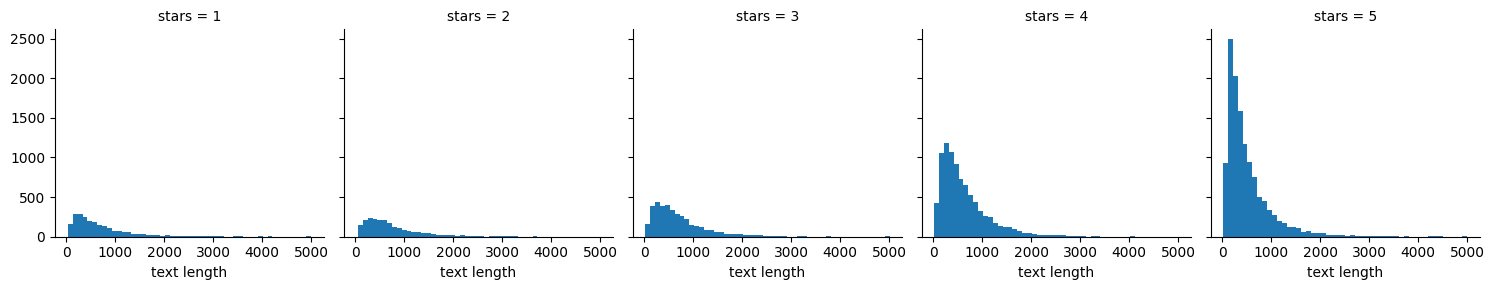

In [77]:
g = sns.FacetGrid(data=df, col='stars')
g.map(plt.hist, 'text length', bins=50)

从五张图的分布可以看出，大多数评论的文本长度都在0～1000左右，随着文本长度的增加，评论的数量越来越少。

In [78]:
stars = df.groupby('stars').mean()
stars.corr()

,cool,funny,useful,text length
cool,1.000000,-0.916240,-0.750145,-0.806934
funny,-0.916240,1.000000,0.952186,0.642570
useful,-0.750145,0.952186,1.000000,0.451883
text length,-0.806934,0.642570,0.451883,1.000000


<AxesSubplot: >

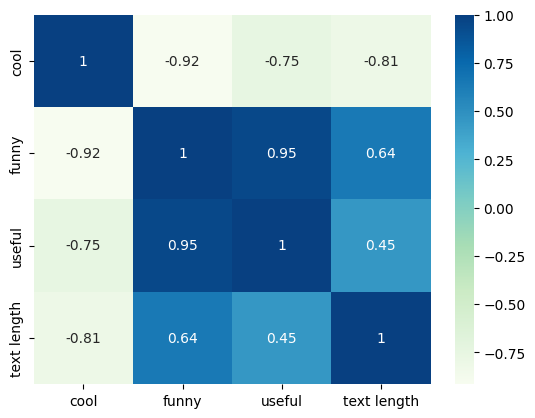

In [79]:
sns.heatmap(data=stars.corr(), annot=True, cmap="GnBu")

Accordimg to the heat map, text length is strongly correlated with funny and useful, and useful seems strongly correlated with funny. We can also see a negative correlation between cool and the other three features.
根据热图，文本长度与有趣和有用密切相关，而有用似乎与有趣密切相关。我们还可以看到酷与其他三个特征之间存在负相关。

# [改]Filter experiment sample and balance sample
我们首先的任务是区分评论是正面还是负面，所以我们先通过stars作为参考，将3星以上的评论归类为1（积极评论），将3星以下的评论归类为0（消极评论），并将他们存在新的列target里

In [91]:
df = df[(df["stars"]!=3)]
df.loc[df['stars'] < 3, 'target'] = 0 
df.loc[df['stars'] > 3, 'target'] = 1

df_target = df[['review_id','business_id','text','target']]

df_target=df_target[df_target['text'].apply(detect)=='en'] #exclude all language other than english
df_target

,review_id,business_id,text,target
0,oyaMhzBSwfGgemSGuZCdwQ,YtSqYv1Q_pOltsVPSx54SA,Tremendous service (Big shout out to Douglas) ...,1.0
1,L0E_Ld__jIATsQ1vA7ZGZw,D4DZztR7vkbiED6txGUYFg,Looks like there is a second Red Kings restaur...,1.0
2,2fD2Do7xBjoahST3FmiwcQ,AY1SyySRyTnBwBdf7qfGxQ,"From the second you walk in the door, you're g...",1.0
3,As1_aGyTE-Sh3jGwh3vG0Q,DsKzHnkLKnxZTVsFpts4oA,We stopped in for brunch and we weren't expect...,1.0
6,g4ujvqodo1km7BbG8F0QOw,NMtUD873aWrNjljt3VOcFA,"Pros:\n\n-Superb cheeseburger - thick, evenly ...",1.0
...,...,...,...,...
29995,xyxdPrQdyTyMl6GPEvfZTQ,ytynqOUb3hjKeJfRj5Tshw,Where do I even begin. This place is massive a...,1.0
29997,cAnAOPyVF4mmzju58piU0Q,v1msvs2bf_LwGUnIcCgSEg,Probably the worst Indian food I've ever had. ...,0.0
29999,TKC8Cke_9sgiM8y0hMoIoA,ytynqOUb3hjKeJfRj5Tshw,"Oh RTM, how do I love thee!\n\n\nMy wife and I...",1.0
30000,dce2HUxO0xM7AUp2so4HnA,N5xoEy9GLtHDvCLa8dMgyA,The food was really delicious and the service ...,1.0


1.0    21538
0.0     4565
Name: target, dtype: int64


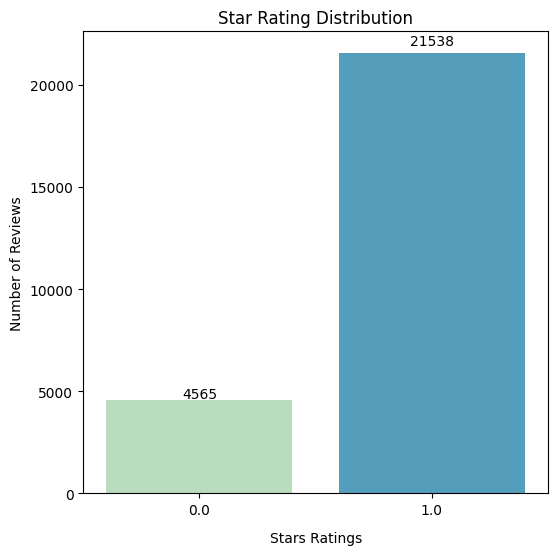

In [93]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

plt.figure(figsize=(6,6))
grouped = df_target.target.value_counts().sort_index()
print(df_target.target.value_counts())
sns.barplot(x=grouped.index, y=grouped.values, palette=sns.color_palette("GnBu", len(grouped)))
plt.xlabel("Stars Ratings", labelpad=10, fontsize=10)
plt.ylabel("Number of Reviews", fontsize=10)
plt.title("Star Rating Distribution", fontsize=12)
plt.tick_params(labelsize=10)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ="center",fontsize=10)

从上图不难看出积极和消极的评论的数量是完全不平衡的，为了让实验更加公平，我们要handle class imbalance using Sklearn Resample<br>
【摘抄】如果正负样本差别很大，或是类别与类别之间相差很大，那么模型就会偏向于预测最常出现的样本。虽然说这样做最后可以获得较高的准确率，但是这个准确率不能说明模型有多好。解决样本不平衡的问题，有两个大的方向是可以解决的。一个是under-sampling，另一个是over-sampling。(A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).<br><br>
We use over-sampling here, upsample minority class (negative review class)

In [94]:
# downsample majority class
# create two different dataframes: one regarding the majority and the other the minority class 
df_majority = df_target[(df_target['target']==1)] 
df_minority = df_target[(df_target['target']==0)] 

df_majority_downsampled = resample(df_majority, 
                                 replace=True,   
                                 n_samples= df_target.target.value_counts()[0],
                                 random_state=42)  
# Combine minority class with downsampled majority class
df_target = pd.concat([df_minority, df_majority_downsampled])
df_target = df_target.reset_index(drop=True)

In [95]:
print(df_target['target'].value_counts())

0.0    4565
1.0    4565
Name: target, dtype: int64


Reason for balancing positvie and negative reviews:
- As we can see our positive reviews are significantly higher than negative reviews, if we using this data to analyze, it will be more biased towards positive reviews compared to negative reviews.  

0.0    4565
1.0    4565
Name: target, dtype: int64


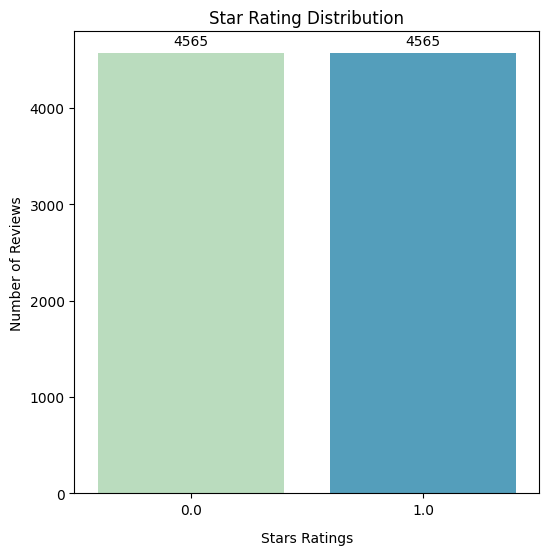

In [96]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

plt.figure(figsize=(6,6))
grouped = df_target.target.value_counts().sort_index()
print(df_target.target.value_counts())
sns.barplot(x=grouped.index, y=grouped.values, palette=sns.color_palette("GnBu", len(grouped)))
plt.xlabel("Stars Ratings", labelpad=10, fontsize=10)
plt.ylabel("Number of Reviews", fontsize=10)
plt.title("Star Rating Distribution", fontsize=12)
plt.tick_params(labelsize=10)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ="center",fontsize=10)

# Clean review texts

In [97]:
sample_text = df_target['text'][3]
sample_text

"It pains me to write this, but I fear I must...\\n\\nI used to really enjoy P&K as a lively neighborhood spot with elevated pub food. But yesterday in the early evening, the place was overrun with drunken frat boys dropping f-bombs at top volume and shouting about their exploits as rapists. After multiple parties complained, asked to be moved, or left altogether, what did the management do? NOTHING! Just kept serving them more beer.\\n\\nIt's hard to justify $25-$30 dishes when the atmosphere is that of no-class dive bar. And skip the octopus. It's overcooked and rubbery.\\n\\nTo be fair, the oysters were excellent; hence the second star."

通告观察该数据集第一行的文本，我们发现文本是plain-text format，里面包含了类似于\n这些我们不需要的内容

【摘抄】The classification algorithm will need some sort of feature vector in order to perform the classification task. The simplest way to convert a corpus to a vector format is the bag-of-words approach, where each unique word in a text will be represented by one number.分类算法需要某种特征向量来执行分类任务。将语料库转换为矢量格式的最简单方法是bag-of-words方法，其中文本中的每个唯一单词将由一个数字表示。<br>
First, let’s write a function that will split a message into its individual words, and return a list. We will also remove the very common words (such as “the”, “a”, “an”, etc.), also known as stopwords. To do this, we can take advantage of the NLTK library. The function below removes punctuation, stopwords, and returns a list of the remaining words, or tokens.
首先，让我们编写一个函数，将一条消息拆分成单独的单词，并返回一个列表。我们还将删除非常常见的词（例如“the”、“a”、“an”等），也称为停用词。为此，我们可以利用 NLTK 库。下面的函数删除标点符号、停用词，并返回剩余单词或标记的列表。

首先使用正则表达式去掉了文本中的URL网址，@用户，#hashtag标签，

In [98]:
def remove_special(text):
    # remove the URL
    text = re.sub(r"http\S+", "", text)
    # remove mentions
    text = re.sub("@[^\s]*", "", text)
    # remove hashtags
    text = re.sub("#[^\s]*", "", text)
    
    return text

接下来我们需要对文本进行Stemming and lemmatization 【paper部分在可以稍微解释一下这两个概念】，将单词转变为token，去掉了不是字母组成的token，并且将它们转化为小写

In [99]:
"""
    logging: 

    if it throws out error as
        ModuleNotFoundError: No module named 'en_core_web_sm',
    make sure that your virtual environment has installed spacy and en_core_web_sm, you can follow the below commands
        pip install -U spacy
        python -m spacy download en_core_web_sm
    my python version is 3.8, and then you can go back JupyterLab and run 
        spacy.load('en_core_web_sm')
    
    reference: 
        https://stackoverflow.com/questions/69284181/modulenotfounderror-no-module-named-en-core-web-sm  
"""
nlp = spacy.load('en_core_web_sm')

def spacy_process(text):
    doc = nlp(text)
    # Lemmatization with Spacy
    lemma_list = []
    for token in doc:
        lemma_list.append(token.lemma_)
            
    #Filter the stopwords, remove non-letters and lower case 
    #filtered_sentence =[]
    #for word in lemma_list:
        #lexeme = nlp.vocab[word]
        #if lexeme.is_stop == False:
            #filtered_sentence.append(word)
    lower_words = []
    for word in lemma_list:
        filtered_aplha_char = re.sub("[^\w]" , " " , word)
        filtered_single_n = re.sub("n\sn", " " ,filtered_aplha_char)
        text_letters_only = re.sub("[^a-zA-Z]", " ", filtered_single_n)
        text_words_lower = text_letters_only.lower()
        remove_single_char = re.sub(r'\b\w\b', '', text_words_lower)
        lower_words.append(remove_single_char)
    text_final = " ".join(lower_words)
    return  " ".join(text_final.split())

In [100]:
sample_text = remove_special(sample_text)
words_sentence = spacy_process(sample_text)
words_sentence

'it pain to write this but fear must use to really enjoy as lively neighborhood spot with elevated pub food but yesterday in the early evening the place be overrun with drunken frat boy drop bomb at top volume and shout about their exploit as rapist after multiple party complain ask to be move or leave altogether what do the management do nothing just keep serve they more beer it hard to justify dish when the atmosphere be that of no class dive bar and skip the octopus it be overcooked and rubbery to be fair the oyster be excellent hence the second star'

### Stop words

In [101]:
my_stop_words = set(stopwords.words('english') + 
                    list(ENGLISH_STOP_WORDS) + 
                    ['super', 'duper', 'place'])
exclude_stopwords = ['no','not','none']
for word in exclude_stopwords:
    my_stop_words.remove(word)
    
#my_stop_words

这里我使用nltk库提供的默认的stopwords，但是去掉了其中的'no','not','none', 因为这些词依然有很强的情感偏向，所以我选择将它们保留在文本中。

In [102]:
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    tokens_list = list()
    for word in word_tokens:
        if word.isalpha() and word not in my_stop_words:
            tokens_list.append(word)
    return tokens_list

def calculate_tokens_freq(tokens_list):
    token_dist = FreqDist(tokens_list)
    return token_dist

tokens_list = remove_stopwords(words_sentence)
print(tokens_list)
calculate_tokens_freq(tokens_list)

['pain', 'write', 'fear', 'use', 'really', 'enjoy', 'lively', 'neighborhood', 'spot', 'elevated', 'pub', 'food', 'yesterday', 'early', 'evening', 'overrun', 'drunken', 'frat', 'boy', 'drop', 'bomb', 'volume', 'shout', 'exploit', 'rapist', 'multiple', 'party', 'complain', 'ask', 'leave', 'altogether', 'management', 'serve', 'beer', 'hard', 'justify', 'dish', 'atmosphere', 'no', 'class', 'dive', 'bar', 'skip', 'octopus', 'overcooked', 'rubbery', 'fair', 'oyster', 'excellent', 'second', 'star']


FreqDist({'pain': 1, 'write': 1, 'fear': 1, 'use': 1, 'really': 1, 'enjoy': 1, 'lively': 1, 'neighborhood': 1, 'spot': 1, 'elevated': 1, ...})

clean text后，此时我们有words_sentence和tokens_list，第一个是将tokens存成string的形式，目的是为了word cloud，第二个是将tokens存成list的形式，目的是为了后续的mining操作。there are no punctuations or stopwords, and the remaining words are returned to us as a list of tokens<br>
为了后续的mining操作，我需要写个集成clean data功能的function，供生成新的csv使用

In [103]:
def clean_data(text, needed_format):
    text = remove_special(text)
    words_sentence = spacy_process(text)
    tokens_list = remove_stopwords(words_sentence)
    tokens_freq_dist = calculate_tokens_freq(tokens_list)
    if needed_format == 'list':
        return tokens_list
    elif needed_format == 'string':
        return words_sentence
    elif needed_format == 'frequent':
        return tokens_freq_dist

---

clean_data方法给我们提供了两种return格式，方便我们生成csv时进行转换。接下来将这个步骤用到dataframe的每一个review里，并且将结果存在cleaned_text的列里，这一步需要等待一段时间

In [104]:
df_target['words'] = df_target['text'].apply(lambda text: clean_data(text,'string'))
#df_target['tokens'] = df_target['text'].apply(lambda text: clean_data(text,'list'))
#df_target['tokens_freq'] = df_target['text'].apply(lambda text: clean_data(text,'frequent'))
df_target.head()

,review_id,business_id,text,target,words
0,fxWnU4OqONBNoQhEcyazSg,krTHKI0YOpASr4gz2CVWFw,"This location used to be good, several years a...",0.0,this location use to be good several year ago ...
1,FhtER9SGsEYkEhRcs09rsQ,krTHKI0YOpASr4gz2CVWFw,I love Cosi but this Cosi is going down hill f...,0.0,love cosi but this cosi be go down hill fast a...
2,0KlwfaHZyvao41_3S47dyg,w9hS5x1F52Id-G1KTrAOZg,Was not a fan of their cheesesteak. Their wiz ...,0.0,be not fan of their cheesesteak their wiz sauc...
3,2qeje7dttkvREbccHev6Pg,7lwe7n-Yc-V9E_HfLAeylg,"It pains me to write this, but I fear I must.....",0.0,it pain to write this but fear must use to rea...
4,1OR23O0giNcxNbFAi4jgcg,DsKzHnkLKnxZTVsFpts4oA,Cocktails were nice however the bartender Paul...,0.0,cocktail be nice however the bartender paul be...


In [105]:
df_target.to_csv("Cleaned_Text_Dataset.csv")

In [106]:
df_target = pd.read_csv("Cleaned_Text_Dataset.csv")

---

## Generate 1-gram result

First we process the reviews columns

In [107]:
df_reviews = pd.DataFrame() # initialize a new dataframe
df_reviews = df_target[['words' , 'target']] #copy text and target columns form df_target
df_reviews = df_reviews[df_reviews['target'] == 1.0] #we only consider positive words
df_reviews = df_reviews[['words']] #keep only reviews column
df_reviews = df_reviews.rename({'words': 'text'}, axis='columns') #rename the column

Text(0.5, 1.0, 'top 20 frequent 1-grams')

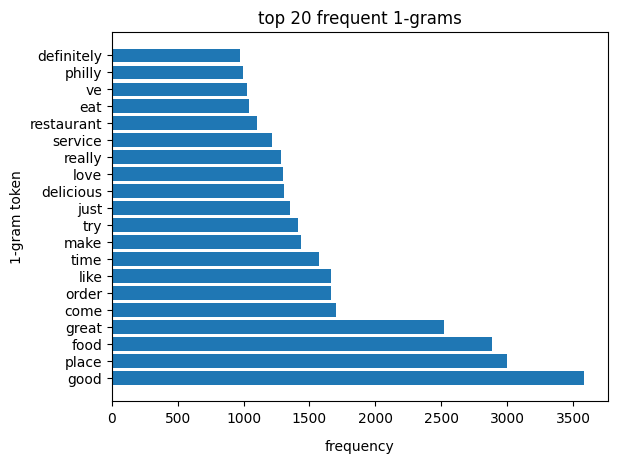

In [108]:
#process the reviews' word and calculate the words frequencies
vect = CountVectorizer(stop_words='english', ngram_range=(1,1))#second attempt on excluding stop words
onegrams = vect.fit_transform(df_reviews['text'])
onegram_df = pd.DataFrame(onegrams.toarray(), columns=vect.get_feature_names_out())
onegram_frequency = pd.DataFrame(onegram_df.sum(axis=0)).reset_index()
onegram_frequency.columns = ['onegram', 'frequency']
onegram_frequency = onegram_frequency.sort_values(by='frequency' , ascending=False).head(20)

#plot the graph
plt.barh(onegram_frequency['onegram'] , onegram_frequency['frequency'])
plt.xlabel("frequency", labelpad=10, fontsize=10)
plt.ylabel("1-gram token", fontsize=10)
plt.title("top 20 frequent 1-grams", fontsize=12)

As we can see 'good' , 'food' , 'great' , 'come' , 'time' came out frquently in positve reviews.

---

## Generate a 2-gram result

Text(0.5, 1.0, 'top 20 frequent bigrams')

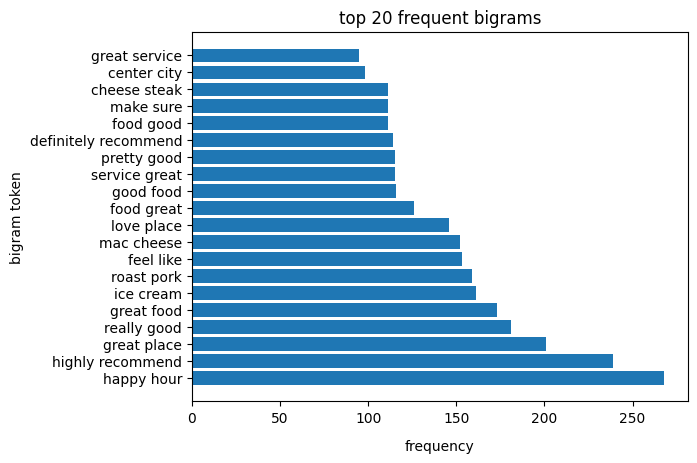

In [109]:
#process the reviews' word and calculate the words frequencies
vect = CountVectorizer(stop_words='english', ngram_range=(2,2))#second attempt on excluding stop words
bigrams = vect.fit_transform(df_reviews['text'])
bigram_df = pd.DataFrame(bigrams.toarray(), columns=vect.get_feature_names_out())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(by='frequency' , ascending=False).head(20)

#plot the graph
plt.barh(bigram_frequency['bigram'] , bigram_frequency['frequency'])
plt.xlabel("frequency", labelpad=10, fontsize=10)
plt.ylabel("bigram token", fontsize=10)
plt.title("top 20 frequent bigrams", fontsize=12)

As we can see 'happy hour' , 'highly recommend' , 'roast pork' , 'ice cream' , 'food good' came out frquently in positve reviews.

---

## Generate a 3-gram result

Text(0.5, 1.0, 'top 20 frequent 3-grams')

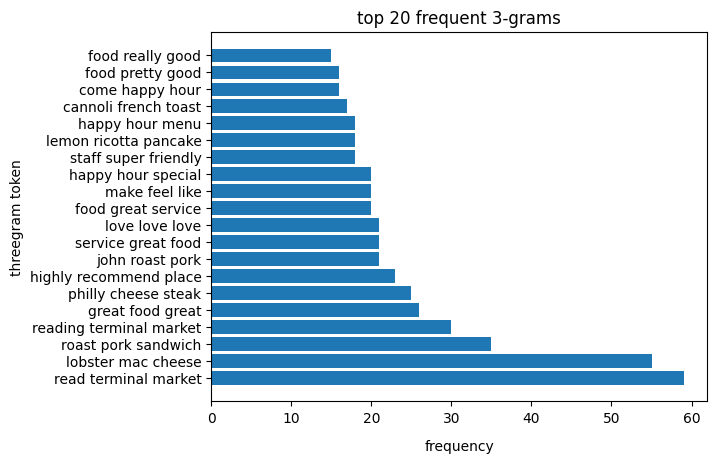

In [110]:
#process the reviews' word and calculate the words frequencies
vect = CountVectorizer(stop_words='english', ngram_range=(3,3))#second attempt on excluding stop words
bigrams = vect.fit_transform(df_reviews['text'])
bigram_df = pd.DataFrame(bigrams.toarray(), columns=vect.get_feature_names_out())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['threegram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(by='frequency' , ascending=False).head(20)

#plot the graph
plt.barh(bigram_frequency['threegram'] , bigram_frequency['frequency'])
plt.xlabel("frequency", labelpad=10, fontsize=10)
plt.ylabel("threegram token", fontsize=10)
plt.title("top 20 frequent 3-grams", fontsize=12)

As we can see the frequencies of 3-gram words are significantly lower.

---

## Generate (1,2)-gram result

Text(0.5, 1.0, 'top 20 frequent (1,2)-grams')

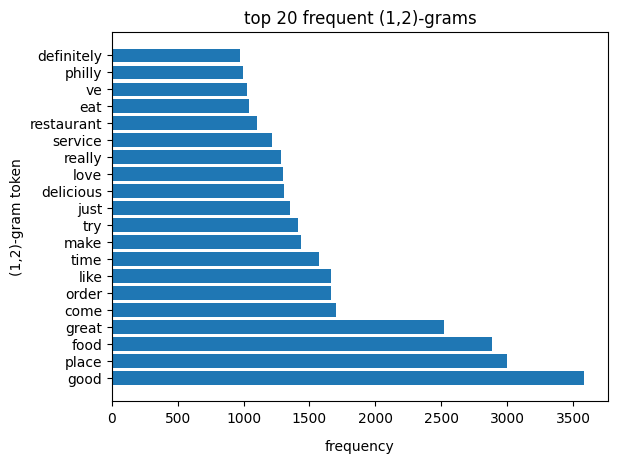

In [111]:
#process the reviews' word and calculate the words frequencies
vect = CountVectorizer(stop_words='english', ngram_range=(1,2)) #second attempt on excluding stop words
bigrams = vect.fit_transform(df_reviews['text'])
bigram_df = pd.DataFrame(bigrams.toarray(), columns=vect.get_feature_names_out())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['(1,2)-gram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(by='frequency' , ascending=False).head(20)

#plot the graph
plt.barh(bigram_frequency['(1,2)-gram'] , bigram_frequency['frequency'])
plt.xlabel("frequency", labelpad=10, fontsize=10)
plt.ylabel("(1,2)-gram token", fontsize=10)
plt.title("top 20 frequent (1,2)-grams", fontsize=12)

As we can see the result is same as one gram result since the frequencies of 1-gram token is higher than bigram token.

---

# Word Cloud 
我们已经通过stars粗略的做了一个评论的积极/消极的区分，并且clean了所有评论的文本，现在简单的通过word cloud的方式观察这些评论里出现的词频

In [112]:
pos = df_target[df_target['target']==1]['words']
neg = df_target[df_target['target']==0]['words']

### positive review word cloud 呈现正面评论或赞美中出现的词频。

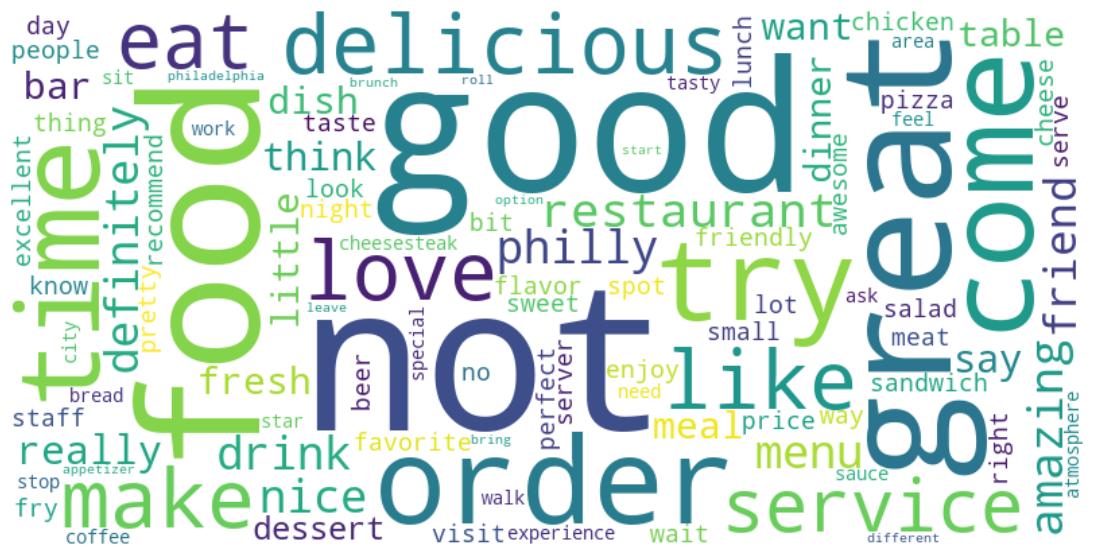

In [113]:
text_pos = " ".join(i for i in pos)
wc_pos = WordCloud(background_color="white", max_words=100, contour_width=10, contour_color='firebrick',
                   stopwords=my_stop_words, width=800, height=400)

# Generate a wordcloud
wc_pos.generate(text_pos)

plt.figure(figsize=(14,7))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

### negative review word cloud 呈现差评或投诉中的词频

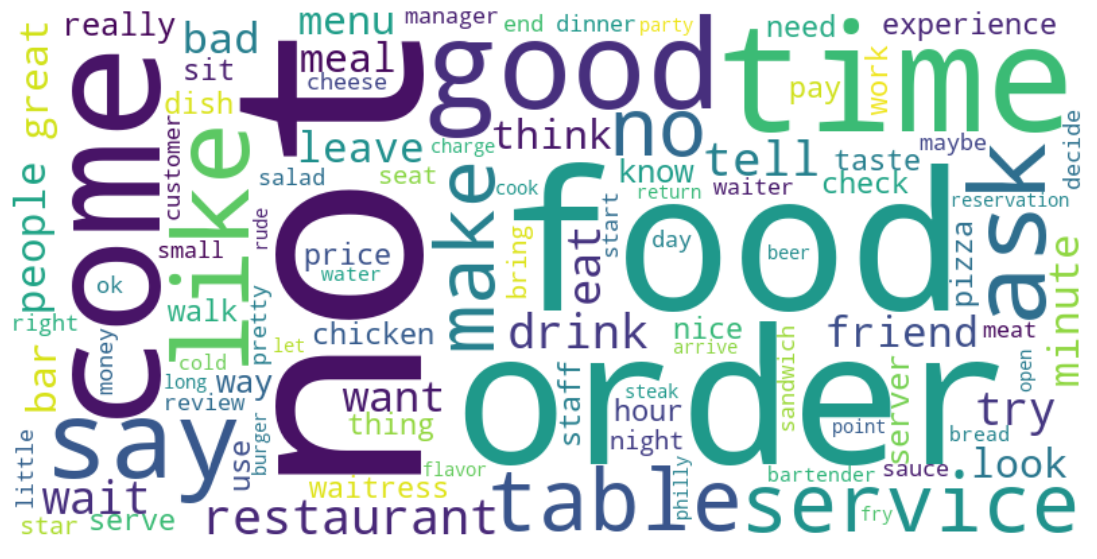

In [116]:
text_neg = " ".join(i for i in neg)
wc_neg = WordCloud(background_color="white", max_words=100, contour_width=10, contour_color='firebrick',
                   stopwords=my_stop_words, width=800, height=400)

wc_neg.generate(text_neg)

plt.figure(figsize=(14,7))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

---

# Word2Vec
利用Word2Vec model去寻找特定单词在上下文中的相关单词

In [117]:
# create a new df that store positive reviews
pos_df = pd.DataFrame() #create pos in df format
pos_df['text'] = df_target['text'] #We have to take in reviews before clean since we need punctuation mark to seperate reviews into sentences
pos_df['target'] = df_target['target']
pos_df = pos_df[pos_df['target'] == 1] #we take only positive reviews
pos_df.reset_index(drop=True)

,text,target
0,I'm going to go against the grain with this re...,1.0
1,"I loved everything about Kanella, from the del...",1.0
2,Having heard a lot about this place for a long...,1.0
3,Overall I am very satisfied with our stay and ...,1.0
4,For the record I only had tea here. I wouldn't...,1.0
...,...,...
4560,I had to return to Philly for a family emergen...,1.0
4561,Our first Philadelphia cheesesteak experience ...,1.0
4562,Went here last weekend with my mom and loved i...,1.0
4563,I had a great time here. The atmosphere was fa...,1.0


### convert all reviews into a string list

In [118]:
pos_text = ' '.join(pos_df.text)
# split the long string into sentences
sentences_pos = sent_tokenize(pos_text)
takens_pos_list = list()
# get tokens for each sentence
for sentence in sentences_pos:
    eng_word = re.findall(r'[A-Za-z\-]+', sentence)
    takens_pos_list.append([i.lower() for i in eng_word if i.lower() not in my_stop_words])

print(sentences_pos[:1])
print(len(sentences_pos))

["I'm going to go against the grain with this review, but there's no way I can give Bliss less than five stars.\\n\\nWe had relatively early reservations on a Friday before going to see a show, and we were armed with a great Groupon."]
32589


In [119]:
print(takens_pos_list[:1])

[['going', 'grain', 'review', 'no', 'way', 'bliss', 'stars', 'n', 'nwe', 'relatively', 'early', 'reservations', 'friday', 'going', 'armed', 'great', 'groupon']]


In [120]:
def run_word2vec(word):
    model_ted = Word2Vec(sentences=takens_pos_list , window=10, min_count=5, workers=4, sg=0)
    return model_ted.predict_output_word([word], topn=20)
    
run_word2vec('service')

[('friendly', 0.41971183),
 ('staff', 0.09022515),
 ('atmosphere', 0.0818629),
 ('service', 0.052164134),
 ('attentive', 0.0480386),
 ('helpful', 0.01850585),
 ('ambiance', 0.008616317),
 ('decor', 0.00670066),
 ('cool', 0.0064443615),
 ('accommodating', 0.0058929445),
 ('quick', 0.0054606316),
 ('waitress', 0.0049944953),
 ('overall', 0.00476842),
 ('servers', 0.0047098063),
 ('knowledgeable', 0.0046476983),
 ('excellent', 0.0045463047),
 ('prices', 0.0044050706),
 ('server', 0.003835514),
 ('reasonable', 0.0037755566),
 ('cozy', 0.0036073532)]

These surrounding words are very informative and they can better explain why people love or explain about certain things.